# The Temple of Speed!

Hopefully Ferrari has a better shot here. Unfortunately my ethics prevent me from influencing my model in their favour despite my wishes otherwise. Enjoy unbiased predictions (we all know which team is going to be at the top of the podium) and keep tissues on standby if you are a Ferrari fan!

In [97]:
%pip install -q --upgrade numpy scikit-learn fastf1 keras xgboost

Note: you may need to restart the kernel to use updated packages.


In [98]:
import fastf1
import pandas as pd
fastf1.Cache.enable_cache("cache")

In [99]:
test=fastf1.get_session(2025, 'Australia','R')
test.load()
test.results

core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core    

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,Laps
4,4,L NORRIS,NOR,norris,McLaren,FF8000,mclaren,Lando,Norris,Lando Norris,...,1.0,1,1.0,NaT,NaT,NaT,0 days 01:42:06.304000,Finished,25.0,57.0
1,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671C6,red_bull,Max,Verstappen,Max Verstappen,...,2.0,2,3.0,NaT,NaT,NaT,0 days 00:00:00.895000,Finished,18.0,57.0
63,63,G RUSSELL,RUS,russell,Mercedes,27F4D2,mercedes,George,Russell,George Russell,...,3.0,3,4.0,NaT,NaT,NaT,0 days 00:00:08.481000,Finished,15.0,57.0
12,12,A ANTONELLI,ANT,antonelli,Mercedes,27F4D2,mercedes,Andrea Kimi,Antonelli,Andrea Kimi Antonelli,...,4.0,4,16.0,NaT,NaT,NaT,0 days 00:00:10.135000,Finished,12.0,57.0
23,23,A ALBON,ALB,albon,Williams,64C4FF,williams,Alexander,Albon,Alexander Albon,...,5.0,5,6.0,NaT,NaT,NaT,0 days 00:00:12.773000,Finished,10.0,57.0
18,18,L STROLL,STR,stroll,Aston Martin,229971,aston_martin,Lance,Stroll,Lance Stroll,...,6.0,6,13.0,NaT,NaT,NaT,0 days 00:00:17.413000,Finished,8.0,57.0
27,27,N HULKENBERG,HUL,hulkenberg,Kick Sauber,52E252,sauber,Nico,Hulkenberg,Nico Hulkenberg,...,7.0,7,17.0,NaT,NaT,NaT,0 days 00:00:18.423000,Finished,6.0,57.0
16,16,C LECLERC,LEC,leclerc,Ferrari,E80020,ferrari,Charles,Leclerc,Charles Leclerc,...,8.0,8,7.0,NaT,NaT,NaT,0 days 00:00:19.826000,Finished,4.0,57.0
81,81,O PIASTRI,PIA,piastri,McLaren,FF8000,mclaren,Oscar,Piastri,Oscar Piastri,...,9.0,9,2.0,NaT,NaT,NaT,0 days 00:00:20.448000,Finished,2.0,57.0
44,44,L HAMILTON,HAM,hamilton,Ferrari,E80020,ferrari,Lewis,Hamilton,Lewis Hamilton,...,10.0,10,8.0,NaT,NaT,NaT,0 days 00:00:22.473000,Finished,1.0,57.0


In [100]:
def get_weather_data(year,race,session):
    cur_session=fastf1.get_session(year,race,session)
    cur_session.load()
    weather_df=cur_session.weather_data
    weather_data={}
    weather_data["AirTemp"]=weather_df["AirTemp"].mean() # Average Air Temp in degrees Celsius
    weather_data["Humidity"]=weather_df["Humidity"].mean() # Average Humidity in % 
    weather_data["Pressure"]=weather_df["Pressure"].mean() # Average Air pressure in mbar
    weather_data["Rain"]=weather_df["Rainfall"].any() # Check if there was any rainfall
    weather_data["WindSpeed"]=weather_df["WindSpeed"].mean() # Average Wind Speed in m/s
    weather_data["TrackTemp"]=weather_df["TrackTemp"].mean() # Average Track Temperature
    
    return weather_data

In [101]:
def get_clean_air_race_pace(year, race):
    all_personal_bests = []
    
    for session in ["FP1", "FP2", "FP3"]:
        try:
            cur_session = fastf1.get_session(year, race, session)
            cur_session.load()
            laps = cur_session.laps
            
            laps = laps.drop(columns=['Time', 'DriverNumber', 'LapNumber', 'Stint',
            'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
            'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
            'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
            'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
            'LapStartDate', 'Position', 'DeletedReason',
            'FastF1Generated', 'IsAccurate'])

            laps = laps[(laps['TrackStatus']=='1') & (laps['Deleted']==False) & (laps.LapTime.notnull())]
            laps = laps.drop(columns=['Deleted','TrackStatus'])

            # Find Personal Best for this session
            personalbest = laps[laps['IsPersonalBest']==True]
            if not personalbest.empty:
                personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
                personalbest = personalbest.drop(columns=['LapTime'])
                personalbest['Session'] = session  # Track which session
                all_personal_bests.append(personalbest)
                
        except Exception as e:
            print(f"Skipping {session} for {year} {race}: {e}")
            continue
    
    # Combine all sessions
    if all_personal_bests:
        combined_bests = pd.concat(all_personal_bests, ignore_index=True)
        
        # Find min lap time per driver across all sessions
        personalbest_map = combined_bests.loc[combined_bests.groupby('Driver')['LapTime (s)'].idxmin()]
        personalbest_map = personalbest_map.reset_index(drop=True)
        
        return personalbest_map
    else:
        return pd.DataFrame()  # Empty if no data found

In [102]:
# Build Model Train Data

train_sessions={2024:['Monza'],2025:['Australia','China','Japan','Bahrain','Saudi Arabia','Miami','Imola','Monaco','Spain','Canada','Austria','Silverstone','Belgium','Hungary','Netherlands']}
train_df=pd.DataFrame()
y=pd.DataFrame()

for year in train_sessions:
    for race in train_sessions[year]:
        cur_session=fastf1.get_session(year,race,'R')
        cur_session.load()
        cur_results=cur_session.results
        
        
        #-------DROP UNNECESSARY COLUMNS----------
        cur_results = cur_results.reset_index(drop=True)
        cur_results=cur_results.drop(columns=['DriverNumber', 'BroadcastName', 'DriverId', 'TeamName',
            'TeamColor', 'FirstName', 'LastName', 'FullName',
            'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
            'Q1', 'Q2', 'Q3', 'Status', 'Points'])
        #-----------------------------------------
        
        cur_results.rename(columns={'Abbreviation':'Driver'},inplace=True)
        #--------CALCULATE TOTAL RACETIME---------
        # cur_results = cur_results.sort_values('Time',ascending=False).reset_index(drop=True)

        # Get winner's time in seconds
        cur_results.reset_index(drop=True,inplace=True)
        winner_time_seconds = cur_results.iloc[0]['Time'].total_seconds()

        cur_results['Time (s)'] = cur_results['Time'].dt.total_seconds()
        cur_results.loc[1:, 'Time (s)'] = winner_time_seconds + cur_results.loc[1:, 'Time (s)']

        #Winner
        cur_results.loc[0, 'Time (s)'] = winner_time_seconds

        cur_results['Time (s)'] = cur_results['Time (s)'].fillna(winner_time_seconds + 300)  # +5 minutes penalty
        
        #-----------------------------------------
        
        
        #-------CALCULATE AVG LAP TIME------------- #REMOVED DUE TO ISSUES WITH HANDLING DNF/DNS
        # cur_results["Average Lap Time (s)"]=cur_results['Time (s)']/cur_results['Laps'].replace(0, 1)
        # Implement Laplace smoothing to handle DNFs
        # cur_results["Average Lap Time (s)"]=(cur_results['Time (s)']+1)/(cur_results['Laps']+1)
        # cur_results.drop(columns=['Time','Laps','Time (s)'],inplace=True)
        #------------------------------------------
        
        #----------CALCULATE TOTAL LAP TIME BY SECTOR AVERAGE---------
        cur_laps = cur_session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
        cur_laps.dropna(inplace=True)

        # convert lap and sector times to seconds
        for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
            cur_laps[f"{col} (s)"] = cur_laps[col].dt.total_seconds()

        # aggregate sector times by driver
        sector_times = cur_laps.groupby("Driver").agg({
            "Sector1Time (s)": "mean",
            "Sector2Time (s)": "mean",
            "Sector3Time (s)": "mean"
        }).reset_index()

        sector_times["TotalSectorTime (s)"] = (
            sector_times["Sector1Time (s)"] +
            sector_times["Sector2Time (s)"] +
            sector_times["Sector3Time (s)"]
        )
        
        cur_results =  cur_results.merge(sector_times[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
        
        y = pd.concat([y,cur_laps.groupby("Driver")["LapTime (s)"].mean().reindex(cur_results["Driver"])])
        #-------------------------------------------------------------
        
        # print(f"{year} {race}: {cur_results['Average Lap Time (s)'].mean():.2f}s avg")
        print(f"{year} {race}: {len(cur_results)} drivers")
        
        #-------FEATURE ENGINEERING----------------
        cur_results['Grid_Gap_to_Pole'] = cur_results['GridPosition'] - cur_results['GridPosition'].min()

        cur_results['Quali_vs_Teammate'] = cur_results.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

        cur_results['Race'] = race
        cur_results['Year'] = year
        #------------------------------------------
        
        #--------GET CLEAN AIR RACE PACE------------
        # Get clean air race pace (best clear track race pace among FP1, FP2 and FP3)
        clean_air_race_pace=get_clean_air_race_pace(year,race)
        
        clean_air_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
        pace_mapping=clean_air_race_pace.set_index('Driver')['LapTime (s)']
        
        cur_results['CleanAirPace_seconds'] = cur_results['Driver'].map(pace_mapping)
        #--------------------------------------------
        
        
        #-------MORE FEATURE ENGINEERING-----------
        cur_results['Practice_Gap_to_Fastest'] = cur_results['CleanAirPace_seconds'] - cur_results['CleanAirPace_seconds'].min()

        cur_results['Practice_vs_Quali_Rank'] = cur_results['CleanAirPace_seconds'].rank() - cur_results['GridPosition']

        cur_results['Quali_vs_Teammate'] = cur_results['Quali_vs_Teammate'].fillna(0)
        #-------------------------------------------

        #-------GET RACE DAY WEATHER DATA------------
        weather_data=get_weather_data(year,race,'R')
        cur_results = cur_results.assign(**weather_data)
        #--------------------------------------------
        
        #------------IS IT MONZA?-----------------
        if race!='Monza':
            cur_results['Is_Monza']=0
        else:
            cur_results['Is_Monza']=1
        
        train_df = pd.concat([train_df, cur_results], ignore_index=True)      
        
        
        
        

core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
core           INFO 	Loading data for Italian Grand Prix - Pr

2024 Monza: 20 drivers


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '10', '11', '12', '14', '16', '18', '20', '22', '23', '24', '27', '31', '43', '44', '55', '77', '81']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Italian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req          

2025 Australia: 20 drivers


req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '7', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '44', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Australian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req      

2025 China: 20 drivers


req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '7', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '44', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INF

Skipping FP2 for 2025 China: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 China: Session type 'FP3' does not exist for this event


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '31', '12', '23', '87', '18', '55', '6', '30', '7', '5', '27', '22', '14', '16', '44', '10']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

2025 Japan: 20 drivers


req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '44', '55', '62', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Japanese Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req       

2025 Bahrain: 20 drivers


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '5', '6', '7', '10', '12', '18', '22', '23', '27', '30', '31', '34', '37', '38', '44', '46', '50', '72', '81']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req           

2025 Saudi Arabia: 20 drivers


req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '7', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '44', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req   

2025 Miami: 20 drivers


req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '7', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '44', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Miami Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 

Skipping FP2 for 2025 Miami: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 Miami: Session type 'FP3' does not exist for this event


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 81 completed the race distance 00:00.036000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '23', '12', '16', '44', '55', '22', '6', '31', '10', '27', '14', '18', '30', '5', '87', '7']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_

2025 Imola: 20 drivers


req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '43', '44', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Emilia Romagna Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req 

2025 Monaco: 20 drivers


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '43', '44', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            

2025 Spain: 19 drivers


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '27', '30', '43', '44', '45', '50', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Spanish Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req           

2025 Canada: 20 drivers


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '43', '44', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Canadian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req          

2025 Austria: 20 drivers


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '5', '6', '10', '12', '14', '18', '22', '23', '27', '30', '31', '38', '43', '44', '55', '63', '81', '87', '89']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Austrian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req         

2025 Silverstone: 20 drivers


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '23', '30', '31', '36', '43', '44', '55', '63', '81', '87', '97']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req           

2025 Belgium: 20 drivers


req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '43', '44', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            IN

Skipping FP2 for 2025 Belgium: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 Belgium: Session type 'FP3' does not exist for this event


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '16', '1', '63', '23', '44', '30', '5', '10', '87', '27', '22', '18', '31', '12', '14', '55', '43', '6']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

2025 Hungary: 20 drivers


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '16', '18', '22', '23', '30', '31', '34', '43', '44', '55', '63', '81', '87', '97']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req         

2025 Netherlands: 20 drivers


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '43', '44', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_17564/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Dutch Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            I

In [103]:
train_df

,Driver,TeamId,GridPosition,Time,Laps,Time (s),TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,...,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Humidity,Pressure,Rain,WindSpeed,TrackTemp,Is_Monza
0,LEC,ferrari,4.0,0 days 01:14:40.727000,53.0,4480.727,84.472077,3.0,-0.5,Monza,...,80.226,0.109,-1.0,33.101504,32.285714,993.228571,False,1.518797,49.311278,1
1,PIA,mclaren,2.0,0 days 00:00:02.664000,53.0,4483.391,84.534000,1.0,0.5,Monza,...,80.252,0.135,2.0,33.101504,32.285714,993.228571,False,1.518797,49.311278,1
2,NOR,mclaren,1.0,0 days 00:00:06.153000,53.0,4486.880,84.575173,0.0,-0.5,Monza,...,80.262,0.145,4.0,33.101504,32.285714,993.228571,False,1.518797,49.311278,1
3,SAI,ferrari,5.0,0 days 00:00:15.621000,53.0,4496.348,84.750058,4.0,0.5,Monza,...,80.463,0.346,2.0,33.101504,32.285714,993.228571,False,1.518797,49.311278,1
4,HAM,mercedes,6.0,0 days 00:00:22.820000,53.0,4503.547,84.882173,5.0,1.5,Monza,...,80.117,0.000,-5.0,33.101504,32.285714,993.228571,False,1.518797,49.311278,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,ANT,mercedes,11.0,0 days 00:00:22.029000,72.0,5931.878,82.132620,10.0,3.0,Netherlands,...,70.697,1.725,6.0,20.077358,71.176101,1006.205660,False,2.170440,27.963522,0
315,GAS,alpine,14.0,0 days 00:00:23.629000,72.0,5933.478,82.353465,13.0,-1.0,Netherlands,...,70.963,1.991,6.0,20.077358,71.176101,1006.205660,False,2.170440,27.963522,0
316,NOR,mclaren,2.0,NaT,64.0,6209.849,80.758079,1.0,0.5,Netherlands,...,68.972,0.000,-1.0,20.077358,71.176101,1006.205660,False,2.170440,27.963522,0
317,LEC,ferrari,6.0,NaT,52.0,6209.849,78.731745,5.0,-0.5,Netherlands,...,69.938,0.966,0.0,20.077358,71.176101,1006.205660,False,2.170440,27.963522,0


In [104]:
train_df.columns

Index(['Driver', 'TeamId', 'GridPosition', 'Time', 'Laps', 'Time (s)',
       'TotalSectorTime (s)', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Race',
       'Year', 'CleanAirPace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
       'WindSpeed', 'TrackTemp', 'Is_Monza'],
      dtype='object')

In [105]:
#Drop Time, Laps, Time (s)

train_df.drop(columns=['Time', 'Laps', 'Time (s)'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Humidity,Pressure,Rain,WindSpeed,TrackTemp,Is_Monza
0,LEC,ferrari,4.0,84.472077,3.0,-0.5,Monza,2024,80.226,0.109,-1.0,33.101504,32.285714,993.228571,False,1.518797,49.311278,1
1,PIA,mclaren,2.0,84.534000,1.0,0.5,Monza,2024,80.252,0.135,2.0,33.101504,32.285714,993.228571,False,1.518797,49.311278,1
2,NOR,mclaren,1.0,84.575173,0.0,-0.5,Monza,2024,80.262,0.145,4.0,33.101504,32.285714,993.228571,False,1.518797,49.311278,1
3,SAI,ferrari,5.0,84.750058,4.0,0.5,Monza,2024,80.463,0.346,2.0,33.101504,32.285714,993.228571,False,1.518797,49.311278,1
4,HAM,mercedes,6.0,84.882173,5.0,1.5,Monza,2024,80.117,0.000,-5.0,33.101504,32.285714,993.228571,False,1.518797,49.311278,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,ANT,mercedes,11.0,82.132620,10.0,3.0,Netherlands,2025,70.697,1.725,6.0,20.077358,71.176101,1006.205660,False,2.170440,27.963522,0
315,GAS,alpine,14.0,82.353465,13.0,-1.0,Netherlands,2025,70.963,1.991,6.0,20.077358,71.176101,1006.205660,False,2.170440,27.963522,0
316,NOR,mclaren,2.0,80.758079,1.0,0.5,Netherlands,2025,68.972,0.000,-1.0,20.077358,71.176101,1006.205660,False,2.170440,27.963522,0
317,LEC,ferrari,6.0,78.731745,5.0,-0.5,Netherlands,2025,69.938,0.966,0.0,20.077358,71.176101,1006.205660,False,2.170440,27.963522,0


In [106]:
train_df.drop(columns=['Humidity'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Monza
0,LEC,ferrari,4.0,84.472077,3.0,-0.5,Monza,2024,80.226,0.109,-1.0,33.101504,993.228571,False,1.518797,49.311278,1
1,PIA,mclaren,2.0,84.534000,1.0,0.5,Monza,2024,80.252,0.135,2.0,33.101504,993.228571,False,1.518797,49.311278,1
2,NOR,mclaren,1.0,84.575173,0.0,-0.5,Monza,2024,80.262,0.145,4.0,33.101504,993.228571,False,1.518797,49.311278,1
3,SAI,ferrari,5.0,84.750058,4.0,0.5,Monza,2024,80.463,0.346,2.0,33.101504,993.228571,False,1.518797,49.311278,1
4,HAM,mercedes,6.0,84.882173,5.0,1.5,Monza,2024,80.117,0.000,-5.0,33.101504,993.228571,False,1.518797,49.311278,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,ANT,mercedes,11.0,82.132620,10.0,3.0,Netherlands,2025,70.697,1.725,6.0,20.077358,1006.205660,False,2.170440,27.963522,0
315,GAS,alpine,14.0,82.353465,13.0,-1.0,Netherlands,2025,70.963,1.991,6.0,20.077358,1006.205660,False,2.170440,27.963522,0
316,NOR,mclaren,2.0,80.758079,1.0,0.5,Netherlands,2025,68.972,0.000,-1.0,20.077358,1006.205660,False,2.170440,27.963522,0
317,LEC,ferrari,6.0,78.731745,5.0,-0.5,Netherlands,2025,69.938,0.966,0.0,20.077358,1006.205660,False,2.170440,27.963522,0


In [107]:
train_df.dtypes

Driver                      object
TeamId                      object
GridPosition               float64
TotalSectorTime (s)        float64
Grid_Gap_to_Pole           float64
Quali_vs_Teammate          float64
Race                        object
Year                         int64
CleanAirPace_seconds       float64
Practice_Gap_to_Fastest    float64
Practice_vs_Quali_Rank     float64
AirTemp                    float64
Pressure                   float64
Rain                          bool
WindSpeed                  float64
TrackTemp                  float64
Is_Monza                     int64
dtype: object

In [108]:
y

,LapTime (s)
LEC,84.472077
PIA,84.534000
NOR,84.575173
SAI,84.750058
HAM,84.882173
...,...
ANT,82.132620
GAS,82.353465
NOR,80.758079
LEC,78.731745


In [109]:
train_df.to_csv("train_df.csv")

Original shape: X(319, 15), y(319, 1)
After cleaning: X(308, 15), y(308, 1)
Debug info:
drivers_test shape: (77,)
drivers_test type: <class 'pandas.core.series.Series'>
lr_test_pred shape: (77, 1)
lr_test_pred type: <class 'numpy.ndarray'>
y_test shape: (77, 1)
y_test type: <class 'pandas.core.frame.DataFrame'>
drivers_test length: 77
lr_test_pred length: 77
y_test length: 77

=== LINEAR REGRESSION ===
Training MAE: 2.048 seconds
Test MAE: 2.412 seconds
Test R²: 0.854

=== RIDGE REGRESSION ===
Training MAE: 2.158 seconds
Test MAE: 2.609 seconds
Test R²: 0.835
X COLUMNS:  Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Year',
       'CleanAirPace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
       'TrackTemp', 'Is_Monza', 'TeamId_encoded', 'Race_encoded'],
      dtype='object')
COEFS :  [ 0.24395096  0.24395096 -0.07539717  2.05964986  0.82182052 -5.42485841
  0.39702557  0.48500079 -0.03108881  7.5800

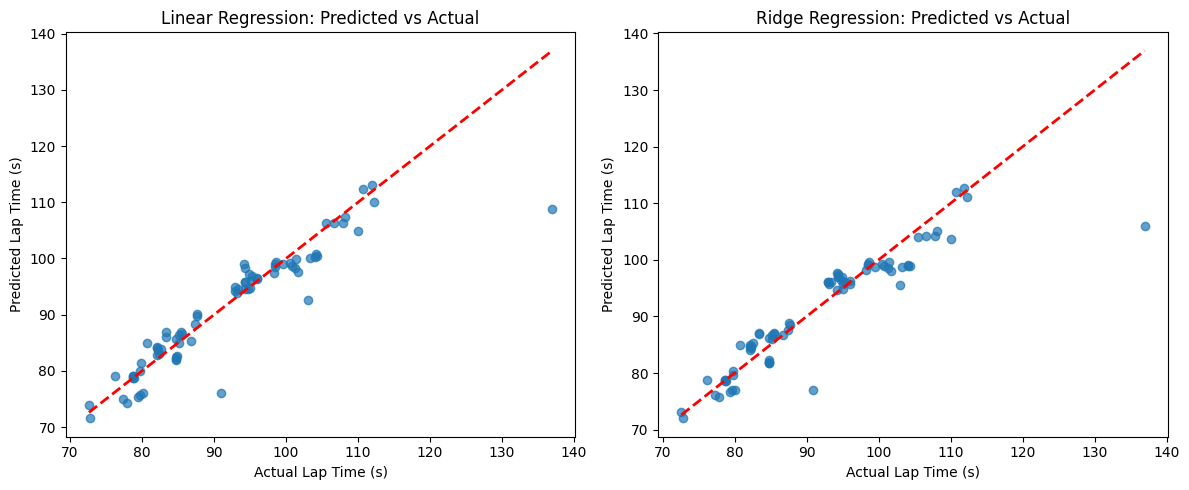


Overfitting Analysis:
Linear Regression gap: 0.364 seconds
Ridge Regression gap: 0.451 seconds


In [110]:
# TRAIN THE MODEL 
# I am using simpler regression models here because earlier tests with XGBoost and ANNs led to severe overfitting due to the lack of data (we only have 80 rows)
# Of course with time there is the option of...drumroll...getting MORE data. But due to time constraints this is what we have to work with.

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

drivers = train_df['Driver'].copy()

# Encode categoricals
le_team = LabelEncoder()
le_race = LabelEncoder()
# le_driver = LabelEncoder()

train_df['TeamId_encoded'] = le_team.fit_transform(train_df['TeamId'])
train_df['Race_encoded'] = le_race.fit_transform(train_df['Race'])
# train_df['Driver_encoded'] = le_driver.fit_transform(train_df['Driver'])

X = train_df.drop(columns=['Driver', 'TeamId', 'Race', 'TotalSectorTime (s)'])
# Handle NaN values
X = X.fillna(0)

# Reset indices to ensure alignment
X_reset = X.reset_index(drop=True)
y_reset = y.reset_index(drop=True) 
drivers_reset = drivers.reset_index(drop=True)

# Now create the boolean mask
valid_indices = y_reset.notna().squeeze()

# Apply the mask
X_clean = X_reset[valid_indices]
y_clean = y_reset[valid_indices]  
drivers_clean = drivers_reset[valid_indices]

print(f"Original shape: X{X_reset.shape}, y{y_reset.shape}")
print(f"After cleaning: X{X_clean.shape}, y{y_clean.shape}")

# Now use the cleaned data for train_test_split
X_train, X_test, y_train, y_test, drivers_train, drivers_test = train_test_split(
    X_clean, y_clean, drivers_clean, test_size=0.25, random_state=42
)

# print(" Y TRAIN : ",y_train)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

ridge_model = Ridge(alpha=10.0) # Increased regularisation to prevent overfitting (from a lot of trial runs...)
ridge_model.fit(X_train, y_train)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)

# Debug the array shapes
print("Debug info:")
print(f"drivers_test shape: {drivers_test.shape}")
print(f"drivers_test type: {type(drivers_test)}")
print(f"lr_test_pred shape: {lr_test_pred.shape}")
print(f"lr_test_pred type: {type(lr_test_pred)}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test type: {type(y_test)}")

# Check if they're all the same length
print(f"drivers_test length: {len(drivers_test)}")
print(f"lr_test_pred length: {len(lr_test_pred)}")
print(f"y_test length: {len(y_test)}")

# Evaluate models
print("\n=== LINEAR REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, lr_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, lr_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, lr_test_pred):.3f}")

print("\n=== RIDGE REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, ridge_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, ridge_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, ridge_test_pred):.3f}")

print("X COLUMNS: ",X.columns)
print("COEFS : ",lr_model.coef_[0])
# Feature importance 
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (Linear Regression):")
print(feature_importance.head(10))

# Convert everything to 1D numpy arrays
drivers_array = np.array(drivers_test).flatten()
pred_array = np.array(lr_test_pred).flatten()
actual_array = np.array(y_test).flatten()

test_results = pd.DataFrame({
    'Driver': drivers_array,
    'Predicted_LapTime': pred_array,
    'Actual_LapTime': actual_array
}).sort_values('Predicted_LapTime')

print("\nPredicted Fastest 3 Drivers (Test Set):")
print(test_results.head(3))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Linear Regression: Predicted vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Ridge Regression: Predicted vs Actual')

plt.tight_layout()
plt.show()

# Check overfitting
overfitting_gap_lr = mean_absolute_error(y_test, lr_test_pred) - mean_absolute_error(y_train, lr_train_pred)
overfitting_gap_ridge = mean_absolute_error(y_test, ridge_test_pred) - mean_absolute_error(y_train, ridge_train_pred)

print(f"\nOverfitting Analysis:")
print(f"Linear Regression gap: {overfitting_gap_lr:.3f} seconds")
print(f"Ridge Regression gap: {overfitting_gap_ridge:.3f} seconds")

In [111]:
# Check correlation between features and target
correlations = X_clean.corrwith(y_clean.squeeze()).abs().sort_values(ascending=False)
print("Feature correlations with target:")
print(correlations.head(10))

# Check for perfect correlations (1.0)
perfect_corr = correlations[correlations > 0.99]
print(f"\nFeatures with correlation > 0.99:")
print(perfect_corr)

Feature correlations with target:
CleanAirPace_seconds       0.829068
TrackTemp                  0.683661
Rain                       0.482387
AirTemp                    0.403446
Practice_Gap_to_Fastest    0.134128
Year                       0.127538
Is_Monza                   0.127538
WindSpeed                  0.118104
Race_encoded               0.099620
GridPosition               0.042452
dtype: float64

Features with correlation > 0.99:
Series([], dtype: float64)


As estimated, Track Temperature, Sector Time and Clean Air Race Pace are the most important features.

In [112]:
X

,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Year,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Monza,TeamId_encoded,Race_encoded
0,4.0,3.0,-0.5,2024,80.226,0.109,-1.0,33.101504,993.228571,False,1.518797,49.311278,1,2,11
1,2.0,1.0,0.5,2024,80.252,0.135,2.0,33.101504,993.228571,False,1.518797,49.311278,1,4,11
2,1.0,0.0,-0.5,2024,80.262,0.145,4.0,33.101504,993.228571,False,1.518797,49.311278,1,4,11
3,5.0,4.0,0.5,2024,80.463,0.346,2.0,33.101504,993.228571,False,1.518797,49.311278,1,2,11
4,6.0,5.0,1.5,2024,80.117,0.000,-5.0,33.101504,993.228571,False,1.518797,49.311278,1,5,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,11.0,10.0,3.0,2025,70.697,1.725,6.0,20.077358,1006.205660,False,2.170440,27.963522,0,5,12
315,14.0,13.0,-1.0,2025,70.963,1.991,6.0,20.077358,1006.205660,False,2.170440,27.963522,0,0,12
316,2.0,1.0,0.5,2025,68.972,0.000,-1.0,20.077358,1006.205660,False,2.170440,27.963522,0,4,12
317,6.0,5.0,-0.5,2025,69.938,0.966,0.0,20.077358,1006.205660,False,2.170440,27.963522,0,2,12


In [113]:
max(X['WindSpeed'])

3.475280898876404

In [114]:
X.columns

Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Year',
       'CleanAirPace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
       'TrackTemp', 'Is_Monza', 'TeamId_encoded', 'Race_encoded'],
      dtype='object')

In [124]:
#----------------CREATE PREDICTION DATASET-----------------

predict_df=pd.DataFrame()
predict_df['Abbreviation']=['PIA','NOR','HAM','LEC','RUS','ANT','LAW','HAD','SAI','ALB','VER','TSU','ALO','STR','BEA','OCO','BOR','HUL','GAS','COL']

# Create driver to team mapping (2025 season)
driver_to_team = {
    'PIA': 'mclaren',
    'NOR': 'mclaren', 
    'HAM': 'ferrari',       
    'LEC': 'ferrari',
    'RUS': 'mercedes',
    'ANT': 'mercedes',      
    'LAW': 'rb',           
    'HAD': 'rb',
    'SAI': 'williams',       
    'ALB': 'williams',
    'VER': 'red_bull',
    'TSU': 'red_bull',           
    'ALO': 'aston_martin',
    'STR': 'aston_martin',
    'BEA': 'haas',          
    'OCO': 'haas',
    'BOR': 'sauber',       
    'HUL': 'sauber',
    'GAS': 'alpine',
    'COL': 'alpine'    
}

predict_df['TeamId'] = predict_df['Abbreviation'].map(driver_to_team)
# predict_df['TeamId_encoded'] = le_team.transform(predict_df['TeamId'])

grid_positions = {
    'VER': 1.0,
    'NOR': 2.0, 
    'PIA': 3.0,
    'LEC': 4.0,
    'RUS': 5.0,
    'ANT': 6.0,       
    'BOR': 7.0,          
    'ALO': 8.0,
    'TSU': 9.0,    
    'HAM': 10.0,
    'BEA': 11.0,            
    'HUL': 12.0,
    'SAI': 13.0,
    'ALB': 14.0,          
    'OCO': 15.0,
    'HAD': 16.0,       
    'STR': 17.0,
    'COL': 18.0,
    'GAS': 19.0,  
    'LAW': 20.0
}


predict_df['GridPosition'] = predict_df['Abbreviation'].map(grid_positions)
predict_df['Grid_Gap_to_Pole'] = predict_df['GridPosition'] - predict_df['GridPosition'].min()
predict_df['Quali_vs_Teammate'] = predict_df.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

predict_df['Race'] = 'Monza'
predict_df['Race_encoded'] = le_race.transform(predict_df['Race']) #2
predict_df['TeamId_encoded']=le_team.transform(predict_df['TeamId'])
predict_df['Year'] = 2025

predict_df['Is_Monza']=1

clean_air_race_pace=get_clean_air_race_pace(2025,'Monza')
clean_air_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
pace_mapping=clean_air_race_pace.set_index('Driver')['LapTime (s)']
predict_df['CleanAirPace_seconds'] = predict_df['Abbreviation'].map(pace_mapping)
        
predict_df['Practice_Gap_to_Fastest'] = predict_df['CleanAirPace_seconds'] - predict_df['CleanAirPace_seconds'].min()
predict_df['Practice_vs_Quali_Rank'] = predict_df['CleanAirPace_seconds'].rank() - predict_df['GridPosition']
predict_df['Quali_vs_Teammate'] = predict_df['Quali_vs_Teammate'].fillna(0)

        
#Predicted Air Temp: 21 Celsius, Pressure= 1008 mbar, windspeed 4 m/s and no Rainfall
predict_df['Rain']=False
predict_df['AirTemp'] = 27.000000
predict_df['TrackTemp']=44.000000
predict_df['Pressure']=1017.100000
predict_df['WindSpeed']=2.777800


predict_df.drop(columns=['TeamId'],inplace=True)
predict_df.drop(columns=['Race'],inplace=True)

predict_df

core           INFO 	Loading data for Italian Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 3
core        WARNING 	No lap data for driver 7
core        WARNING 	No lap data for driver 9
core        WARNING 	No lap data for driver 11
core        WARNING 	No lap data for driver 15
core        WARNING 	No lap data for driver 17
core        WARNING 	No lap data for driver 19
core        WARNING 	No lap data for driver 21
core        WARNING 	No lap d

,Abbreviation,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Race_encoded,TeamId_encoded,Year,Is_Monza,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,Rain,AirTemp,TrackTemp,Pressure,WindSpeed
0,PIA,3.0,2.0,0.5,11,4,2025,1,79.496,0.165,0.0,False,27.0,44.0,1017.1,2.7778
1,NOR,2.0,1.0,-0.5,11,4,2025,1,79.331,0.000,-1.0,False,27.0,44.0,1017.1,2.7778
2,HAM,10.0,9.0,3.0,11,2,2025,1,79.598,0.267,-3.0,False,27.0,44.0,1017.1,2.7778
3,LEC,4.0,3.0,-3.0,11,2,2025,1,79.352,0.021,-2.0,False,27.0,44.0,1017.1,2.7778
4,RUS,5.0,4.0,-0.5,11,5,2025,1,79.515,0.184,0.0,False,27.0,44.0,1017.1,2.7778
5,ANT,6.0,5.0,0.5,11,5,2025,1,79.696,0.365,3.0,False,27.0,44.0,1017.1,2.7778
6,LAW,20.0,19.0,2.0,11,6,2025,1,80.132,0.801,-4.0,False,27.0,44.0,1017.1,2.7778
7,HAD,16.0,15.0,-2.0,11,6,2025,1,79.603,0.272,-8.0,False,27.0,44.0,1017.1,2.7778
8,SAI,13.0,12.0,-0.5,11,9,2025,1,79.907,0.576,0.0,False,27.0,44.0,1017.1,2.7778
9,ALB,14.0,13.0,0.5,11,9,2025,1,79.720,0.389,-4.0,False,27.0,44.0,1017.1,2.7778


In [125]:
predict_df.columns

Index(['Abbreviation', 'GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate',
       'Race_encoded', 'TeamId_encoded', 'Year', 'Is_Monza',
       'CleanAirPace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'Rain', 'AirTemp', 'TrackTemp', 'Pressure',
       'WindSpeed'],
      dtype='object')

In [126]:
# Reorder prediction features to match training order
feature_order = ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Year', 
                'CleanAirPace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 
                'AirTemp', 'Pressure', 'Rain', 'WindSpeed','TrackTemp','Is_Monza', 'TeamId_encoded', 'Race_encoded']

#CHECK HERE IN DUTCH GP NOTEBOOK FOR DIFFERENCES IN FEATURE ENGINEERING
# REMOVE DRIVER_ENCODED

X_predict = predict_df[feature_order]

# Handle missing values
X_predict = X_predict.fillna(0)

# print("Feature alignment check:")
# print("Training:", list(X.columns))
# print("Prediction:", list(X_predict.columns))
# print("Match:", list(X.columns) == list(X_predict.columns))

#Make Predictions
predicted_lap_times = ridge_model.predict(X_predict)

print("PREDICTIONS")
print(predicted_lap_times)

results_df = pd.DataFrame({
    'Driver': predict_df['Abbreviation'],
    'Predicted_LapTime': predicted_lap_times
}).sort_values('Predicted_LapTime')

# Get top 3 fastest 
print("\nPREDICTED 2025 MONZA PODIUM")
print("===============================")
print(f"🥇 P1: {results_df.iloc[0]['Driver']} - {results_df.iloc[0]['Predicted_LapTime']}s")
print(f"🥈 P2: {results_df.iloc[1]['Driver']} - {results_df.iloc[1]['Predicted_LapTime']}s") 
print(f"🥉 P3: {results_df.iloc[2]['Driver']} - {results_df.iloc[2]['Predicted_LapTime']}s")

print("\nFull Results:")
results_df.reset_index(drop=True, inplace=True)
print(results_df.head(10))

PREDICTIONS
[90.01096895 89.97137238 90.866969   90.32051674 90.62637734 91.0143069
 92.48883164 92.03949621 92.15068049 92.01239219 90.45946694 91.50229589
 91.46921835 92.05920559 91.85746246 92.31103386 91.1608889  91.83395674
 92.4041016  91.9912764 ]

PREDICTED 2025 MONZA PODIUM
🥇 P1: NOR - 89.9713723797272s
🥈 P2: PIA - 90.01096894712623s
🥉 P3: LEC - 90.32051674327181s

Full Results:
  Driver  Predicted_LapTime
0    NOR          89.971372
1    PIA          90.010969
2    LEC          90.320517
3    VER          90.459467
4    RUS          90.626377
5    HAM          90.866969
6    ANT          91.014307
7    BOR          91.160889
8    ALO          91.469218
9    TSU          91.502296


In [127]:
ridge_prediction=ridge_model.predict(X_predict)
ridge_prediction

array([90.01096895, 89.97137238, 90.866969  , 90.32051674, 90.62637734,
       91.0143069 , 92.48883164, 92.03949621, 92.15068049, 92.01239219,
       90.45946694, 91.50229589, 91.46921835, 92.05920559, 91.85746246,
       92.31103386, 91.1608889 , 91.83395674, 92.4041016 , 91.9912764 ])

In [128]:
ridge_model.score(X_test,y_test)

0.8353183542393696

In [129]:
coefs = pd.DataFrame(
    abs(ridge_model.coef_), columns=["Coefficients"], index=X_train.columns
)
coefs.columns

Index(['Coefficients'], dtype='object')

In [130]:
coefs.sort_values(by='Coefficients',ascending=False)

,Coefficients
Rain,5.773267
WindSpeed,3.553506
Practice_Gap_to_Fastest,3.018009
Is_Monza,0.893724
Year,0.893724
CleanAirPace_seconds,0.797023
Race_encoded,0.405192
TrackTemp,0.385190
AirTemp,0.329862
Practice_vs_Quali_Rank,0.191934


In [131]:
# FUTURE WORK
# Normalisation of features
# Add in skill based ranking?
# Constructor Standing/points?
